In [51]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
import sklearn
import cv2
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

In [47]:
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
test_csv_path ='../../data/AF/Waveform_30/test/'
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
test_data=torch.empty(len(test_data_list),1,3000)
test_label=torch.empty(len(test_data_list),1)
for i in range(len(test_data_list)):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(resized(signal_csv,3000))
    test_label[i]=torch.tensor([AF_signal_label])
test_dataset=CustomDataset(test_data ,test_label)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [48]:
from sympy import flatten


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(6000, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,3000))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 3000]           200
├─ReLU: 1-2                              [256, 50, 3000]           --
├─Dropout1d: 1-3                         [256, 50, 3000]           --
├─MaxPool1d: 1-4                         [256, 50, 600]            --
├─Conv1d: 1-5                            [256, 50, 600]            7,550
├─ReLU: 1-6                              [256, 50, 600]            --
├─Dropout1d: 1-7                         [256, 50, 600]            --
├─MaxPool1d: 1-8                         [256, 50, 120]            --
├─Linear: 1-9                            [256, 200]                1,200,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 1,207,950
Trainable params: 1,207,950
Non-trainable params: 0
Total mult-adds (G): 1.62
Input size (MB): 3.07
Forward/backward pa

In [49]:
model.eval()
model.load_state_dict(torch.load('../../model/Waveform/Type_All/BiLSTM_CNN_1D_30_TypeAll_call_back.pt'))
m = nn.Sigmoid()
y_30_100Hz=torch.empty((0,1))
predict_30_100Hz=torch.empty((0,1))
with torch.no_grad():
    for x, y in test_dataloader:
        y = y.to(device0).float()
        x=x.to(device0).float()
        y_30_100Hz=torch.cat([y_30_100Hz,y.cpu()])
        predict = model(x).to(device0)
        predict_30_100Hz=torch.cat([predict_30_100Hz,m(predict).cpu()])
        acc=accuracy(predict, y)
        cost = criterion(predict, y)
        


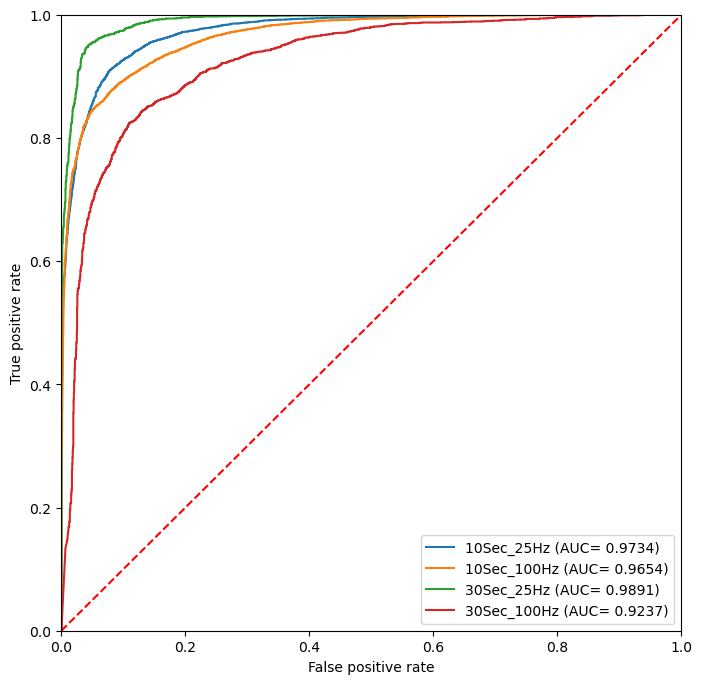

In [77]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
fpr1, tpr1, cut1 = roc_curve(y_10_25Hz,predict_10_25Hz)
y_10_25Hz_score=roc_auc_score(y_10_25Hz,predict_10_25Hz)
fpr2, tpr2, cut2 = roc_curve(y_10_100Hz,predict_10_100Hz)
y_10_100Hz_score=roc_auc_score(y_10_100Hz,predict_10_100Hz)
fpr3, tpr3, cut3 = roc_curve(y_30_25Hz,predict_30_25Hz)
y_30_25Hz_score=roc_auc_score(y_30_25Hz,predict_30_25Hz)
fpr4, tpr4, cut4 = roc_curve(y_30_100Hz,predict_30_100Hz)
y_30_100Hz_score=roc_auc_score(y_30_100Hz,predict_30_100Hz)
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(fpr1, tpr1, label='10Sec_25Hz (AUC= %.4f)'%y_10_25Hz_score )
ax.plot(fpr2, tpr2, label='10Sec_100Hz (AUC= %.4f)'%y_10_100Hz_score)
ax.plot(fpr3, tpr3, label='30Sec_25Hz (AUC= %.4f)'%y_30_25Hz_score)
ax.plot(fpr4, tpr4, label='30Sec_100Hz (AUC= %.4f)'%y_30_100Hz_score)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim([0, 1])      # X축의 범위: [xmin, xmax]
ax.set_ylim([0, 1])     # Y축의 범위: [ymin, ymax]
ax.set_xlabel('False positive rate')      # X축의 범위: [xmin, xmax]
ax.set_ylabel('True positive rate')
ax.legend()
plt.show()

Threshholds= 0.417 f1-score=0.9589175089664167
              precision    recall  f1-score   support

      Non-AF       0.94      0.95      0.95      2286
          AF       0.97      0.95      0.96      3090

    accuracy                           0.95      5376
   macro avg       0.95      0.95      0.95      5376
weighted avg       0.95      0.95      0.95      5376



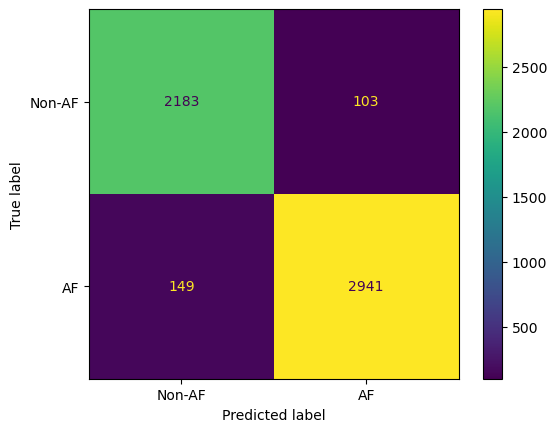

In [83]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from copy import copy
a=np.linspace(0.000,1.000,1001)
report1=0
tresh_hold=0.000
for i in a:
    t_prob=np.where(predict_30_25Hz>i,1,0)
    report = f1_score(y_30_25Hz,t_prob)
    if report1<=report:
        tresh_hold=copy(i)
        report1=copy(report)
print(f"Threshholds= {tresh_hold} f1-score={report1}")
classes = ['Non-AF','AF']
t_prob=np.where(predict_30_25Hz>tresh_hold,1,0)
report = classification_report(y_30_25Hz, t_prob, target_names=classes)
cm = confusion_matrix(y_30_25Hz, t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()

print(report)